## Материалы

---
**Презентация** (https://yadi.sk/i/ZRyD6BU5cT0j7g)

# Анализ программы лояльности магазина строительных материалов 

### Шаг №1. Открыть файл с данными и изучить общую информацию<a id="step1"></a>

---
Проведем импорт необходимых библиотек:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from scipy import stats as st
import seaborn as sns
import matplotlib.ticker as plticker
import warnings
warnings.filterwarnings("ignore")
import plotly.express as px
from plotly import graph_objects as go
import datetime as dt
from datetime import datetime
import math
import urllib.request

Загрузим данные и сохраним их в переменные retail и product_codes соответственно. Создадим функцию df_info для просмотра основной информации по датафреймам и применим ее для наших датасетов.

In [3]:
def df_info(df):
    """вывод основной информации по датафрейму"""
    df.info()
    display(df.describe())
    display(df)

**Таблица retail**

In [4]:
display(df_info(retail))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105335 entries, 0 to 105334
Data columns (total 7 columns):
purchaseid         105335 non-null object
item_ID            105335 non-null object
Quantity           105335 non-null int64
purchasedate       105335 non-null object
CustomerID         69125 non-null float64
ShopID             105335 non-null object
loyalty_program    105335 non-null float64
dtypes: float64(2), int64(1), object(4)
memory usage: 5.6+ MB


,Quantity,CustomerID,loyalty_program
count,105335.000000,69125.000000,105335.000000
mean,7.821218,21019.302047,0.226345
std,327.946695,1765.444679,0.418467
min,-74216.000000,18025.000000,0.000000
25%,0.000000,19544.000000,0.000000
50%,2.000000,20990.000000,0.000000
75%,7.000000,22659.000000,0.000000
max,74214.000000,23962.000000,1.000000


,purchaseid,item_ID,Quantity,purchasedate,CustomerID,ShopID,loyalty_program
0,538280,21873,11,2016-12-10 12:50:00,18427.0,Shop 0,0.0
1,538862,22195,0,2016-12-14 14:11:00,22389.0,Shop 0,1.0
2,538855,21239,7,2016-12-14 13:50:00,22182.0,Shop 0,1.0
3,543543,22271,0,2017-02-09 15:33:00,23522.0,Shop 0,1.0
4,543812,79321,0,2017-02-13 14:40:00,23151.0,Shop 0,1.0
...,...,...,...,...,...,...,...
105330,538566,21826,1,2016-12-13 11:21:00,NaN,Shop 0,0.0
105331,540247,21742,0,2017-01-05 15:56:00,21143.0,Shop 0,0.0
105332,538068,85048,1,2016-12-09 14:05:00,23657.0,Shop 0,1.0
105333,538207,22818,11,2016-12-10 11:33:00,18427.0,Shop 0,0.0


None

В таблице 7 столбцов и порядка 105 тысяч строк. Что можно сказать на первый взгляд:
1. Сразу видим что названия столбцов не приведены к нижнему регистру и вообще записаны не в одном стиле - требуется преобразование. 
2. Посмотрим на типы данных в столбцах: столбцы с идентификатороми покупки и пользователя имеют тип object, хотя в таблице значения этих столбцов - числа (на первый взгляд) - нужно будет изучить так ли это; дата покупки также имеет тип object хотя должен быть временной, CustomerID имеет тип флоат, хотя числа целые; loyalty_program - также имеет тип флоат, хотя значения всего два (1 - есть в программе, 0 - нет). Одним словом тип данных также нужно изменить на этапе предобработки. 
3. В столбце CustomerID есть пропуски (порядка 35 тысяч пропущенных значений) - нужно разобраться почему и заполнить пропуски.
4. В столбце quantity видим что есть отрицательные значения - посмотрим сколько их и разберемся с ними.

In [5]:
display(retail.query('Quantity < 0').head(5))

,purchaseid,item_ID,Quantity,purchasedate,CustomerID,ShopID,loyalty_program
64,C539944,22776,-2,2016-12-23 11:38:00,20239.0,Shop 0,0.0
109,C542910,20726,-2,2017-02-01 15:38:00,23190.0,Shop 0,1.0
112,C542426,22418,-25,2017-01-28 09:32:00,19825.0,Shop 0,0.0
253,C539726,22791,-11,2016-12-21 14:24:00,22686.0,Shop 0,1.0
344,C544034,21878,-2,2017-02-15 11:28:00,20380.0,Shop 0,0.0


**Таблица product_codes**

In [6]:
display(df_info(product_codes))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9969 entries, 0 to 9968
Data columns (total 2 columns):
productID        9969 non-null object
price_per_one    9969 non-null float64
dtypes: float64(1), object(1)
memory usage: 155.9+ KB


,price_per_one
count,9969.000000
mean,19.503697
std,330.880754
min,0.000000
25%,1.250000
50%,2.550000
75%,5.510000
max,16888.020000


,productID,price_per_one
0,85123A,2.55
1,71053,3.39
2,84406B,2.75
3,84029G,3.39
4,84029E,3.39
...,...,...
9964,84306,8.29
9965,90001A,4.15
9966,90118,2.46
9967,DOT,172.62


None

В таблице около 10 тысяч строк и 2 столбца: идентификатор продукта и стоимость единицы товара. Идентификатор продукта есть и в таблице retail и мы видим по значениям столбца что ID имеет не только цифровую запись, в нем есть также и буквы. Значит в таблице retail тип данных object для столбца ID товара верный. Для этой таблицы нужео будет:
1. изменить названия столбцов и привести к нижнему регистру
2. типы данных верные: object для идентификатора и float64 для цены
3. пропущенных значений нет, хотя видим что есть нулевые ценники. Возможно товар шел в подарок или нулевая цена была в рамках промоакции.
4. нужно будет проверить столбец с ID на дубликаты, так как ценник на один и тот же товар может быть разным (например, в рамках той же промоакции он мог идти по нулевой цене, а его реальная стоимость другая. В результате этого у нас будет 2 разных цены на один ID)

### Шаг №2. Предобработка данных<a id="step2"></a>

---
**Заменить названия столбцов и привести к нижнему регистру**<a id="step3"></a>

---
Приведем названия столбцов к нижнему регистру и переименуем названия столбцов в удобные. Можно было использовать конструкцию retail.columns = [x.lower() for x in retail.columns], но поскольку мы все равно собираемся переименовать столбцы, то просто поменяем названия без использования этой функции.

In [7]:
retail.columns = ['purchase_id', 'item_id', 'quantity', 'purchase_date', 'customer_id', 'shop_id', 'loyalty_program']
product_codes.columns = ['item_id', 'price_per_one']

Таким образом, теперь названия столбцов записаны в нижнем регистре, более удобные для восприятия и столбец ИД товара одинаково называется в обеих таблицах. Переходим к следующему пункту.

**Преобразовать данные в нужные типы. Описать, в каких столбцах заменили тип данных и почему**<a id="step4"></a>

---
В таблице product_codes типы данных верны, поэтому преобразования требуются только для таблицы retail. Взглянем на нее более детально.

1. item_id, quantity, shop_id - типы данных верные.
2. Столбец **purchase_id**: взглянув на уникальные значения столбца видим что есть и буквы в строках, т.е. тип данных object верный.
3. Столбец **purchase_date**: преобразуем во временной тип с помощью pd.to_datetime().
4. Столбец **customer_id**: преобразуем тип данных float64 в int. Сделаем это после обработки пропущенных значений.
5. Столбец **loyalty_program**: преобразуем тип данных float64 в int.

In [8]:
retail['purchase_date'] = pd.to_datetime(retail['purchase_date'])
retail['loyalty_program'] = retail['loyalty_program'].astype('int64')

In [9]:
display(retail.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105335 entries, 0 to 105334
Data columns (total 7 columns):
purchase_id        105335 non-null object
item_id            105335 non-null object
quantity           105335 non-null int64
purchase_date      105335 non-null datetime64[ns]
customer_id        69125 non-null float64
shop_id            105335 non-null object
loyalty_program    105335 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 5.6+ MB


None

Теперь типы данных верны (кроме customer_id, который мы преобразуем после обработки пропусков). К пропускам теперь и переходим.

**Обработать пропуски при необходимости (объяснить, почему заполнили пропуски определённым образом или почему не стали это делать, описать причины, которые могли привести к пропускам)**<a id="step5"></a>

---
Пропуски, как мы определили, есть только в столбце **customer_id** таблицы retail. Посчитаем сколько их методом isnull() вместе с sum(). 

In [10]:
display(retail['customer_id'].isnull().sum())

36210

36120  пропусков - очень много для того чтобы просто удалить. Подумаем логически, один номер чека - один покупатель. Поскольку в номерах чеков пропусков нет, то заменим пропущенные значения столбца customer_id значениями столбца purchase_id. Мы не сможем отследить кто из покупателей (без ИД) имеет несколько чеков, но при этом сохраним большую часть данных для анализа.

In [11]:
retail['customer_id'] = retail['customer_id'].fillna(retail['purchase_id'])
display(retail['customer_id'].isnull().sum())

0

Пропусков больше нет, все данные сохранили, но теперь и менять тип данных столбца customer_id нет смысла: во-первых там теперь есть буквы в идентификаторах, а во-вторых он сам поменялся с флоат на object. Теперь самое время проверить данные на дубликаты.

**Проверить данные на наличие дубликатов**<a id="step6"></a>

---
Сначала проверим сами датасеты на наличие полных строк-дубликатов методом duplicated().sum().

In [12]:
display(retail.duplicated().sum())
display(product_codes.duplicated().sum())

1033

0

Как видим в таблице retail 1033 полных дубликата, что нас не устраивает - даже если все было бы идентично, то время покупки не могло быть одинаковым. Поэтому удалим их методом drop_duplicates().

In [13]:
retail = retail.drop_duplicates().reset_index(drop = True)
product_codes = product_codes.drop_duplicates().reset_index(drop = True)
display(retail.duplicated().sum())
display(product_codes.duplicated().sum())

0

0

Теперь проанализируем могут ли быть "ненужные дубликаты" в столбцах таблиц. Для таблицы retail: по каждому отдельно взятому столбцу дубликаты быть могут. А вот для таблицы product_codes, которая является словарем, в столбце item_id дубликатов быть не должно. Один код товара - одна цена. Проверим столбец на дубликаты:

In [14]:
display(product_codes['item_id'].duplicated().sum())

6810

Неприятная ситуация: на 10000 строк почти 7 тысяч дубликатов. А если учесть, что полных строк дубликатов в таблице нет, то получается следущий момент - на большое количество товаров есть несколько цен. Поскольку реальную цену каждого товара у нас нет возможности, то воспользуемся медианой: для каждого ИД товара найдем медианное значение цены.

In [15]:
product_codes_new = product_codes.pivot_table(index='item_id', values='price_per_one', aggfunc='median').reset_index()
display(product_codes_new)

,item_id,price_per_one
0,10002,1.630
1,10080,0.850
2,10120,0.210
3,10123C,0.650
4,10124A,0.420
...,...,...
3154,gift_0001_20,16.845
3155,gift_0001_30,25.265
3156,gift_0001_40,34.040
3157,gift_0001_50,42.550


В итоге наш датафрейм сократился на 2/3 и получилось 3159 уникальных пар ИД товара - цена. 

Обе таблицы преобразованы - самое время объединить их в одну методом merge(). После этого посмотрим на смердженную таблицу методом info().

In [16]:
retail_merge = retail.merge(product_codes_new,  how = 'outer', on = ['item_id'])

In [17]:
display(df_info(retail_merge))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104302 entries, 0 to 104301
Data columns (total 8 columns):
purchase_id        104302 non-null object
item_id            104302 non-null object
quantity           104302 non-null int64
purchase_date      104302 non-null datetime64[ns]
customer_id        104302 non-null object
shop_id            104302 non-null object
loyalty_program    104302 non-null int64
price_per_one      104302 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 7.2+ MB


,quantity,loyalty_program,price_per_one
count,104302.000000,104302.000000,104302.000000
mean,7.883003,0.224464,5.299516
std,329.565540,0.417231,69.549226
min,-74216.000000,0.000000,0.000000
25%,0.000000,0.000000,1.650000
50%,2.000000,0.000000,3.040000
75%,7.000000,0.000000,5.205000
max,74214.000000,1.000000,6706.710000


,purchase_id,item_id,quantity,purchase_date,customer_id,shop_id,loyalty_program,price_per_one
0,538280,21873,11,2016-12-10 12:50:00,18427,Shop 0,0,1.63
1,541104,21873,0,2017-01-13 14:29:00,541104,Shop 0,0,1.63
2,540418,21873,1,2017-01-07 11:04:00,540418,Shop 0,0,1.63
3,541516,21873,2,2017-01-18 17:34:00,541516,Shop 0,0,1.63
4,541566,21873,35,2017-01-19 11:50:00,23401,Shop 0,1,1.63
...,...,...,...,...,...,...,...,...
104297,538852,90058B,35,2016-12-14 13:33:00,23051,Shop 0,1,0.38
104298,539988,46138B,1,2016-12-23 16:06:00,23795,Shop 0,1,1.95
104299,537025,90053,0,2016-12-03 16:21:00,537025,Shop 0,0,2.55
104300,542731,17028J,5,2017-01-31 15:27:00,19279,Shop 0,0,0.42


None

**Подведем итоги предобработки:**
1. Названия столбцов приведены к нижнему регистру и переименованы на более удобные.
2. Данные приведены к нужным типам
3. Пропуски обработаны и при этом мы не потеряли около 35 тысяч записей как если бы просто удалили их.
4. Дубликаты удалены, как полные строки - в таблице retail, так и одинаковые ИД товара - в таблице продуктовых кодов. Параллельно с этим создан датафрейм с уникальными парами код-цена, где цену мы взяли как медиану по ценам каждого уникального товара.
5. Таблицы после всех обработок мы объединили, получив общий датафрейм со всеми интересующими нас данными.

### Шаг №3. Провести исследовательский анализ данных (EDA)<a id="step7"></a>

---
**Посмотреть, за какой период наши данные. Проверить полные ли они на всем периоде или нет**<a id="step8"></a>

---
Выделим из столбца purchase_date дату и сохраним в столбец date. Проверим за какой период мы располагаем данными. Найдем с помощью функций min() и max() минимальную и максимальную даты в нашем датафрейме.

In [18]:
retail_merge['date'] = retail_merge['purchase_date'].dt.date
retail_merge['date'] = pd.to_datetime(retail_merge['date'])

In [19]:
display('Мы располагаем данными с {} по {}'.format(retail_merge['date'].min().strftime('%Y-%m-%d'),retail_merge['date'].max().strftime('%Y-%m-%d')))

'Мы располагаем данными с 2016-12-01 по 2017-02-28'

Мы имеем данные с 1 декабря 2016 года по 28 февраля 2017 года, т.е. три полных месяца. На этот период приходится новый год, поэтому наши данными могут быть неполными - вряд ли строительный магазин пользуется популярностью в новогодние праздники. Построим распределение количества покупок по датам, также добавив деление по программе лояльности. Воспользуемся для этого методом pivot_table().

**Построить график распределения количества покупок по дням**<a id="step9"></a>

---
Получим сводную таблицу для каждой даты, значения - количество покупок, столбцы - клиенты неучаствующие в программе лояльности cnt_0, участвующие cnt_1 и объединенный столбец cnt_all. 

In [20]:
purchase_by_date = retail_merge.pivot_table(index='date', columns = 'loyalty_program', values='purchase_id',aggfunc='nunique').reset_index()
purchase_by_date.columns = ['date', 'cnt_0', 'cnt_1']
purchase_by_date['cnt_all'] = purchase_by_date['cnt_0'] + purchase_by_date['cnt_1']
display(purchase_by_date)

,date,cnt_0,cnt_1,cnt_all
0,2016-12-01,94,49,143
1,2016-12-02,101,66,167
2,2016-12-03,83,25,108
3,2016-12-05,69,26,95
4,2016-12-06,89,44,133
...,...,...,...,...
63,2017-02-23,46,22,68
64,2017-02-24,42,24,66
65,2017-02-25,42,9,51
66,2017-02-27,27,8,35


Обратим внимание что даты есть не все (после 3 декабря сразу идет 5-е, а значит есть дни когда покупок не было). Построим распределение всех чеков по дням и посмотрим на него.

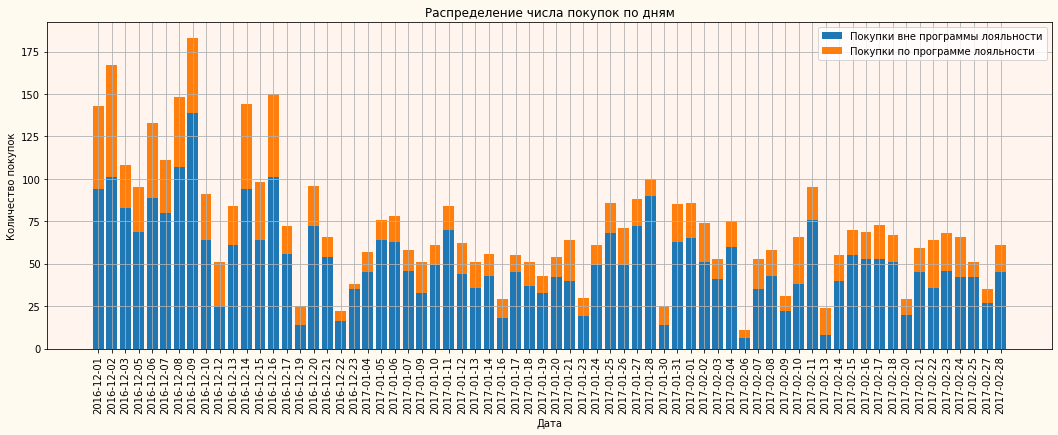

In [21]:
x = purchase_by_date['date'].map(lambda x: dt.datetime.strftime(x, '%Y-%m-%d'))
y1 = purchase_by_date['cnt_0']
y2 = purchase_by_date['cnt_1']

fig, ax = plt.subplots()

ax.bar(x, y1, label='Покупки вне программы лояльности')
ax.bar(x, y2, bottom = y1, label='Покупки по программе лояльности')
ax.set_facecolor('seashell')
fig.set_facecolor('floralwhite')
fig.set_figwidth(18)    #  ширина Figure
fig.set_figheight(6)    #  высота Figure
ax.grid()

ax.set_title('Распределение числа покупок по дням')
ax.set_xlabel('Дата')
ax.set_ylabel('Количество покупок')
ax.set_xticklabels(x, rotation=90)
ax.legend()
plt.show();

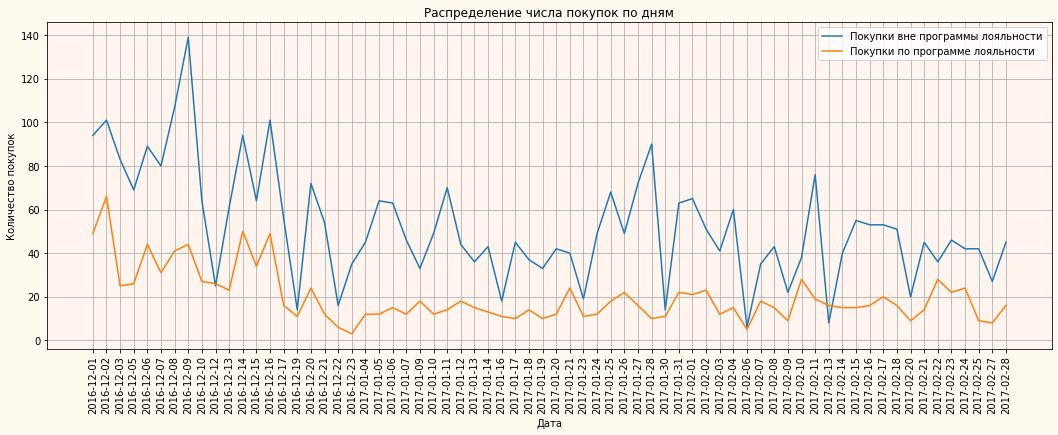

In [22]:
x = purchase_by_date['date'].map(lambda x: dt.datetime.strftime(x, '%Y-%m-%d'))
y1 = purchase_by_date['cnt_0']
y2 = purchase_by_date['cnt_1']

fig, ax = plt.subplots()

ax.plot(x, y1, label='Покупки вне программы лояльности')
ax.plot(x, y2, label='Покупки по программе лояльности')
ax.set_facecolor('seashell')
fig.set_facecolor('floralwhite')
fig.set_figwidth(18)    #  ширина Figure
fig.set_figheight(6)    #  высота Figure
ax.grid()

ax.set_title('Распределение числа покупок по дням')
ax.set_xlabel('Дата')
ax.set_ylabel('Количество покупок')
ax.set_xticklabels(x, rotation=90)
ax.legend()
plt.show();

На что нужно обратить внимание,глядя на этот график:
1. До середины декабря покупок было значительно больше, чем в январе и феврале. Причем распределение в январе и феврале достаточно равномерное
2. Отсутствуют данные с 24 декабря по 3 января: магазин не работал? люди не покупали? или просто данные потерялись?
3. Также данные отсутствуют для 1 дня в неделю: 4.12, 11.12, 18.12... в эти дни профилактика? или инвентаризация? или раз в неделю выгрузка сбоит и мы не получаем данных?
4. Количество покупок вне программы лояльности больше, чем число покупок по программе.

<div class="alert alert-block alert-info">

5. График распределения по дням для "лояльных" клиентов более плавный, в то время как у "нелояльных" график идет скачками.
</div>

**Построить гистограмму, отображающую количество покупок на покупателей.**<a id="step10"></a>

---
Проведем такие же действия как и в предыдущем пункте, но с небольшими отличиями. Во-первых у нас получатся пропущенные значения, так как вряд ли покупатель с картой лояльности будет делать покупки без нее (проверил, таких нет).

In [23]:
purchase_by_customer = retail_merge.pivot_table(index='customer_id', columns = 'loyalty_program', values='purchase_id',aggfunc='nunique').reset_index()
purchase_by_customer.columns = ['customer', 'cnt_0', 'cnt_1']
display(purchase_by_customer.describe())

,cnt_0,cnt_1
count,1910.000000,587.000000
mean,1.858639,2.289608
std,2.576014,2.520485
min,1.000000,1.000000
25%,1.000000,1.000000
50%,1.000000,1.000000
75%,2.000000,3.000000
max,46.000000,35.000000


In [24]:
display(purchase_by_customer['cnt_0'].describe())

count    1910.000000
mean        1.858639
std         2.576014
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        46.000000
Name: cnt_0, dtype: float64

Максимальное число покупок на одного пользователя равно 46 для клиентов вне программы лояльности и 35 - для тех кто в программе лояльности, а средние значения 1,85 и 2,3 соответственно, а по медиане - всего 1 покупка для обеих категорий.

Построим гистограмму распределения покупок по покупателям.

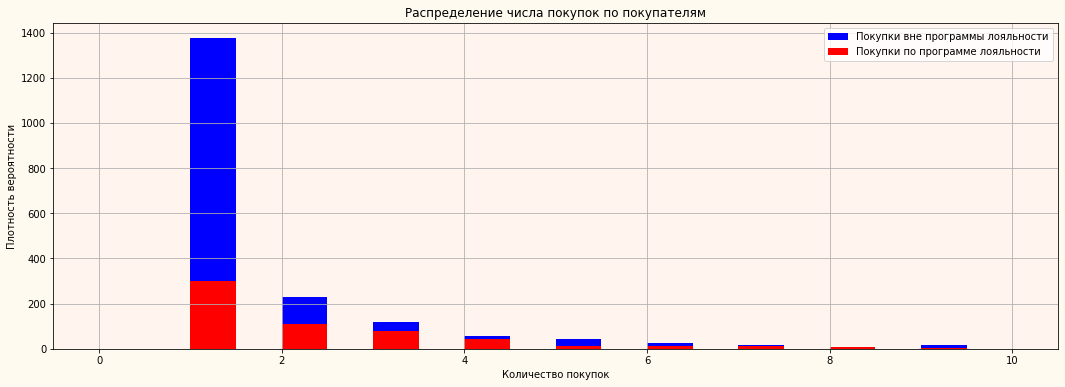

In [25]:
x = purchase_by_customer['cnt_0']
x1 = purchase_by_customer['cnt_1']
fig, ax = plt.subplots()

ax.hist(x, color='b', Label='Покупки вне программы лояльности', range=(0, 10), bins=10, width=0.5)
ax.hist(x1, color='r', Label='Покупки по программе лояльности', range=(0, 10), bins=10, width=0.5)

ax.set_facecolor('seashell')
fig.set_facecolor('floralwhite')
fig.set_figwidth(18)    #  ширина Figure
fig.set_figheight(6)    #  высота Figure
ax.grid()

ax.set_title('Распределение числа покупок по покупателям')
ax.set_xlabel('Количество покупок')
ax.set_ylabel('Плотность вероятности')
ax.legend()
plt.show();

<div class="alert alert-block alert-info">

Судя по графику количество покупок "лояльных" покупателей меньше, но мы видим что у "нелояльных" покупателей очень большое количество одиночных покупок. Это получилось из-за того, что мы присвоили в предобработке ИД чека ИД пользователю чтобы не терять данные и у нас получилось что у всех пропущенных значений пользователя только один чек на одного покупателя. Из-за этого получились также и искаженные средние значения.

Не очень хочется отбрасывать эту метрику (тем более что от этого пострадает и метрика среднего чека, и метрика выручки на покупателя), поэтому признаем ошибку и уберем из таблицы retail_merge все строки где purchase_id = customer_id. Правда полная таблица нам еще пригодится для построения графика выручки по магазинам.
</div>

In [26]:
retail_real = retail_merge.query('purchase_id != customer_id').reset_index(drop=True)

In [27]:
purchase_by_customer = retail_real.pivot_table(index='customer_id', columns = 'loyalty_program', values='purchase_id',aggfunc='nunique').reset_index()
purchase_by_customer.columns = ['customer', 'cnt_0', 'cnt_1']

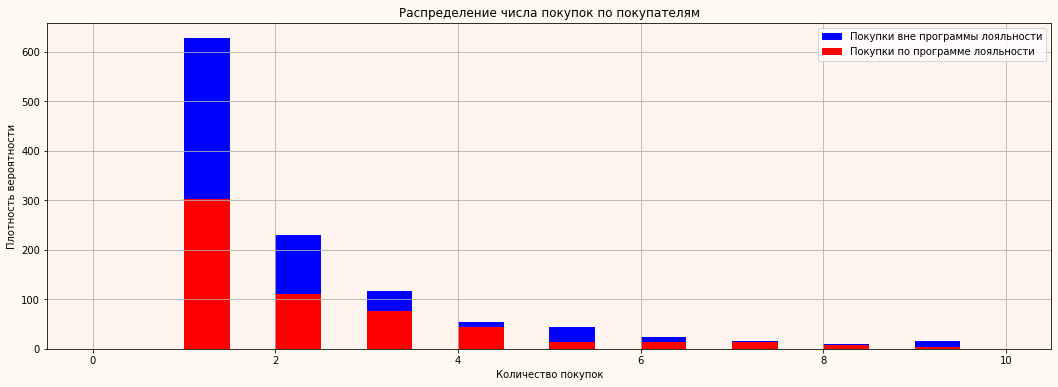

In [28]:
x = purchase_by_customer['cnt_0']
x1 = purchase_by_customer['cnt_1']
fig, ax = plt.subplots()

ax.hist(x, color='b', Label='Покупки вне программы лояльности', range=(0, 10), bins=10, width=0.5)
ax.hist(x1, color='r', Label='Покупки по программе лояльности', range=(0, 10), bins=10, width=0.5)

ax.set_facecolor('seashell')
fig.set_facecolor('floralwhite')
fig.set_figwidth(18)    #  ширина Figure
fig.set_figheight(6)    #  высота Figure
ax.grid()

ax.set_title('Распределение числа покупок по покупателям')
ax.set_xlabel('Количество покупок')
ax.set_ylabel('Плотность вероятности')
ax.legend()
plt.show();

<div class="alert alert-block alert-info">

Картина сразу поменялась. Вместо почти 1400 одиночных чеков теперь их стало чуть больше 600. Собственно изменения коснулись только "нелояльных" покупателей с одним чеком, но благодаря этому мы увидели более реальную картину. Посмотрим как изменились средние значения.
</div>

In [29]:
display(purchase_by_customer.describe())

,customer,cnt_0,cnt_1
count,1749.000000,1162.000000,587.000000
mean,20969.564322,2.411360,2.289608
std,1749.210776,3.182826,2.520485
min,18025.000000,1.000000,1.000000
25%,19465.000000,1.000000,1.000000
50%,20960.000000,1.000000,1.000000
75%,22529.000000,3.000000,3.000000
max,23962.000000,46.000000,35.000000


Как видим, средние значения изменились для группы без лояльности и остались теми же для второй группы: в среднем теперь 2,4 и 2,3 покупок на покупателя. 

Для нас важно то, что по таким результатам мы можем сделать предварительный вывод: количество покупок на покупателя не зависит от присутствия в системе лояльности. Эту теорию нам предстоит проверить статистически.

**Постройте диаграмму, отображающую соотношение количества покупок по различным магазинам.**<a id="step11"></a>

---
Проведем такие же действия как и в предыдущих пунктах.

In [30]:
purchase_by_shop = retail_merge.pivot_table(index='shop_id', columns = 'loyalty_program', values='purchase_id',aggfunc='nunique').reset_index()
purchase_by_shop.columns = ['shop', 'cnt_0', 'cnt_1']
display(purchase_by_shop)

,shop,cnt_0,cnt_1
0,Shop 0,3134.0,1337.0
1,Shop 1,90.0,NaN
2,Shop 10,15.0,NaN
3,Shop 11,10.0,NaN
4,Shop 12,21.0,NaN
5,Shop 13,4.0,NaN
6,Shop 14,6.0,NaN
7,Shop 15,2.0,NaN
8,Shop 16,4.0,NaN
9,Shop 17,2.0,NaN


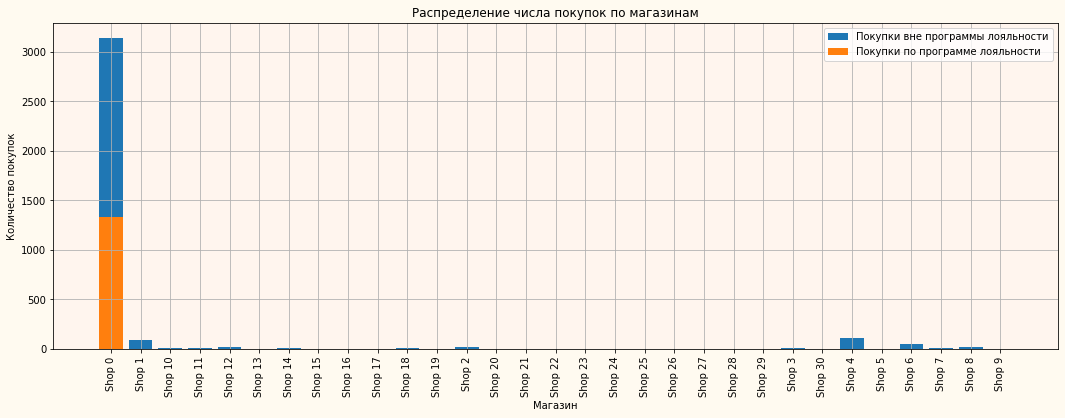

In [31]:
x = purchase_by_shop['shop']

y1 = purchase_by_shop['cnt_0']
y2 = purchase_by_shop['cnt_1']

fig, ax = plt.subplots()

ax.bar(x, y1, label='Покупки вне программы лояльности')
ax.bar(x, y2, label='Покупки по программе лояльности')
ax.set_facecolor('seashell')
fig.set_facecolor('floralwhite')
fig.set_figwidth(18)    #  ширина Figure
fig.set_figheight(6)    #  высота Figure
ax.grid()

ax.set_title('Распределение числа покупок по магазинам')
ax.set_xlabel('Магазин')
ax.set_ylabel('Количество покупок')
ax.set_xticklabels(x, rotation=90)
ax.legend()
plt.show();

<div class="alert alert-block alert-info">
    
Подавляющее большинство покупок приходятся на магазин "shop_0" - 3134 и 1337 чеков на нелояльных и лояльных соответственно - вероятно, это оптовый магазин.  
    
Построим график без учета магазина 0 и взглянем как обстоят дела у розницы.

</div>

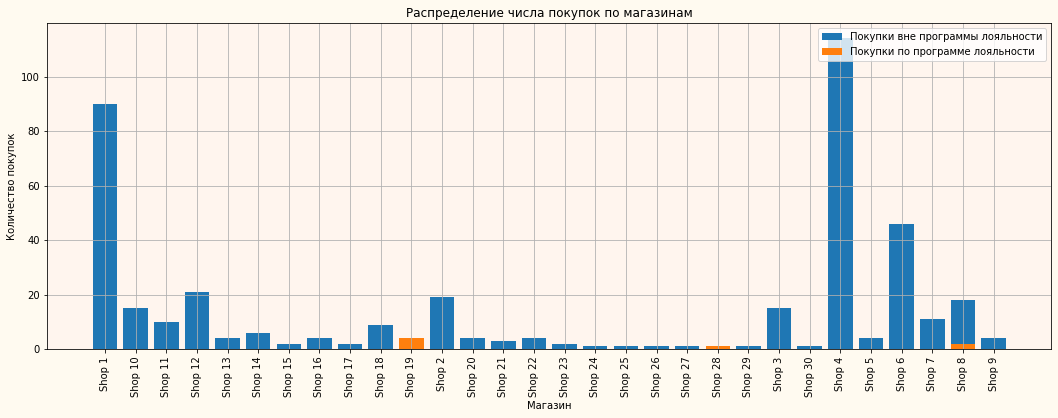

In [32]:
purchase_by_shop_0 = purchase_by_shop.query('shop != "Shop 0"')

x = purchase_by_shop_0['shop']
y1 = purchase_by_shop_0['cnt_0']
y2 = purchase_by_shop_0['cnt_1']

fig, ax = plt.subplots()

ax.bar(x, y1, label='Покупки вне программы лояльности')
ax.bar(x, y2, label='Покупки по программе лояльности')
ax.set_facecolor('seashell')
fig.set_facecolor('floralwhite')
fig.set_figwidth(18)    #  ширина Figure
fig.set_figheight(6)    #  высота Figure
ax.grid()

ax.set_title('Распределение числа покупок по магазинам')
ax.set_xlabel('Магазин')
ax.set_ylabel('Количество покупок')
ax.set_xticklabels(x, rotation=90)
ax.legend()
plt.show();


<div class="alert alert-block alert-info">
    


Не учитывая магизин 0:
1. "Лояльные" покупатели совершают покупки только в 4 магазинах: 0, 8, 19 и 28. Почему? Продавцы не информируют о картах лояльности? Но тогда смысла от их введения точно не будет, если покупатель об этом даже не знает.
2. Только у четырех магазинов набралось более 20 продаж: 1, 4, 6, 12. Это очень низкий показатель для трехмесячного периода. Встает резонный вопрос о целесообразности содержать столько магазинов. Стоит указать на это заказчику.
    
</div>

**Сгруппировать таблицу по покупателям и программе лояльности. Добавить в таблицу столбец выручки и среднего чека.**<a id="step12"></a>

---
Я собираюсь сравнить метрики среднего чека и выручки по покупателям, поэтому буду дальше пользоваться таблицей retail_real. Добавим в нее столбец выручки с товара, умножив цену на количество.

In [33]:
retail_real['revenue'] = retail_real['quantity'] * retail_real['price_per_one']
display(retail_real.head(5))

,purchase_id,item_id,quantity,purchase_date,customer_id,shop_id,loyalty_program,price_per_one,date,revenue
0,538280,21873,11,2016-12-10 12:50:00,18427,Shop 0,0,1.63,2016-12-10,17.93
1,541566,21873,35,2017-01-19 11:50:00,23401,Shop 0,1,1.63,2017-01-19,57.05
2,538843,21873,1,2016-12-14 13:18:00,21712,Shop 0,0,1.63,2016-12-14,1.63
3,540838,21873,11,2017-01-11 15:13:00,19541,Shop 0,0,1.63,2017-01-11,17.93
4,543592,21873,5,2017-02-10 11:57:00,22922,Shop 0,1,1.63,2017-02-10,8.15


Для дальнейшей работы нам требуется преобразовать нашу таблицу: сперва сгруппируем наших покупателей по присутствию в системе лояльности и ИД покупателя, сделав столбцами суммарную выручку и количество уникальных чеков. Затем переименуем столбцы для удобства и добавим столбец среднего чека: разделим выручку на количество чеков.

In [34]:
customer_retail = retail_real.groupby(['loyalty_program', 'customer_id']).agg({'purchase_id': ['nunique'], 'revenue':['sum']}).reset_index()
customer_retail.columns = ['loyalty_program', 'customer_id', 'purchase_count', 'revenue_sum']
customer_retail['avg_bill'] = round(customer_retail['revenue_sum'] / customer_retail['purchase_count'], 2)
display(customer_retail.describe())

,loyalty_program,customer_id,purchase_count,revenue_sum,avg_bill
count,1749.000000,1749.000000,1749.000000,1749.000000,1749.000000
mean,0.335620,20969.564322,2.370497,1137.193007,432.618645
std,0.472342,1749.210776,2.976829,3935.424536,847.406267
min,0.000000,18025.000000,1.000000,-32922.105000,-10974.030000
25%,0.000000,19465.000000,1.000000,202.665000,137.790000
50%,0.000000,20960.000000,1.000000,439.465000,265.870000
75%,1.000000,22529.000000,3.000000,930.440000,501.120000
max,1.000000,23962.000000,46.000000,101301.125000,15824.540000


**Построить точечный график среднего чека. Сделать выводы и предположения.** <a id="step13"></a>

---
Если дорогой заказ попадёт в одну из групп теста, он сразу же исказит результаты и сделает победителем ту группу, где оказался. При этом такие покупки — редкость, исключение, которое проявилось не из-за тестирования гипотезы, а случайно. Такие аномально дорогие заказы следует удалять из теста. Но поскольку у нас в таблице стоит выручка не с одного заказа, а со всех для пользователя, то более разумно отсеять аномальные средние чеки.

In [35]:
display(customer_retail.sort_values(by='avg_bill',ascending=False).head(10))

,loyalty_program,customer_id,purchase_count,revenue_sum,avg_bill
1001,0,21428.0,2,31649.080,15824.54
24,0,18094.0,3,34452.210,11484.07
527,0,19767.0,1,10912.060,10912.06
1699,1,23781.0,6,55970.180,9328.36
701,0,20325.0,11,101301.125,9209.19
145,0,18434.0,1,6260.270,6260.27
582,0,19937.0,2,10527.070,5263.54
143,0,18432.0,3,15429.465,5143.16
36,0,18130.0,1,4873.195,4873.20
194,0,18618.0,2,8664.140,4332.07


<div class="alert alert-block alert-info">
    
Отсортировав таблицу по убыванию выручки мы сразу можем обратить внимание на то, что каких-то сверхвыбивающихся средних чеков не видно. Есть 3 больших чека (дороже 10 тысяч), но на глаз определить аномальные они или нет трудно.
    
</div>


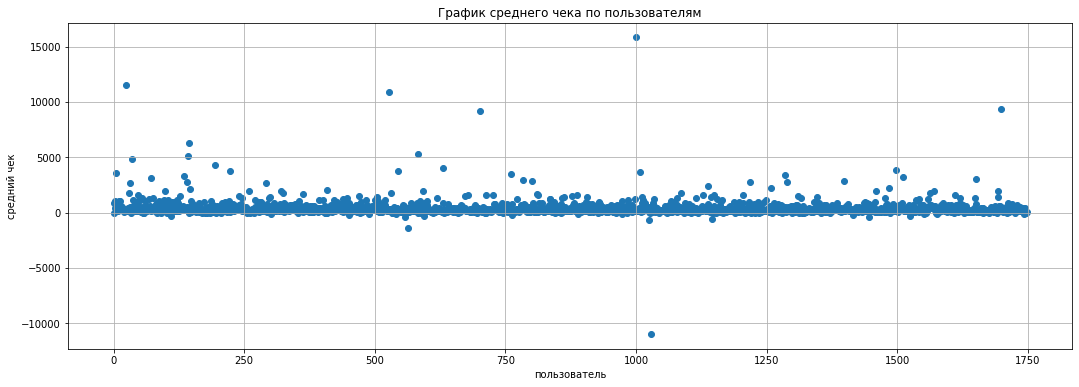

In [36]:
xx_values = pd.Series(range(0,len(customer_retail['avg_bill'])))

fig, ax = plt.subplots()
fig.set_figwidth(18)
fig.set_figheight(6)
ax.set_title('График среднего чека по пользователям')
ax.set_xlabel('пользователь')
ax.set_ylabel('средний чек')
ax.grid()


plt.scatter(xx_values, customer_retail['avg_bill'])

График, что вполне естественно, подтверждает данные в таблице. Сложно сказать где проходит граница аномальных заказов по графику - для этого посчитаем перцентили.


<div class="alert alert-block alert-info">
    
Мы получили интересный момент - у нас есть отрицательные средние чеки и получились они от возвратов. Поскольку если покупка и возврат пришлись бы на рассматриваемый период, то в сумме у нас получился бы 0, а раз значение отрицательное - в таблице есть возвраты за покупки, совершенные до исследуемого периода. Установим нижнюю границу за 0, чтобы эти возвраты не исказили нам картину.
    
</div>

**Посчитать 95-й и 99-й перцентили стоимости заказов. Выбрать границу для определения аномальных заказов.** <a id="step14"></a>

In [37]:
display(np.percentile(customer_retail['avg_bill'], [95, 99]))

array([1229.848 , 3388.2616])

<div class="alert alert-block alert-info">
    
Не более 5% заказов имеют средний чек 1330. И только 1% покупок имеют средний чек 3388. Принято отсеивать от 1% до 5% наблюдений с крайними значениями. Возьмем средний чек в 3400 за границу стоимости заказа и отсеивать аномальные покупки будем по ней.
    
</div>


**Построить точечный график количества заказов по пользователям. Сделать выводы и предположения.** <a id="step15"></a>

---
Проведем действия,  аналогичные построению графику выручки.

In [38]:
display(customer_retail.sort_values(by='purchase_count',ascending=False).head(10))

,loyalty_program,customer_id,purchase_count,revenue_sum,avg_bill
142,0,18427.0,46,4943.925,107.48
689,0,20285.0,38,2416.170,63.58
1618,1,23529.0,35,6996.830,199.91
884,0,20990.0,33,18321.425,555.19
1614,1,23520.0,30,4195.115,139.84
243,0,18768.0,29,21548.690,743.06
779,0,20590.0,28,16585.720,592.35
813,0,20740.0,21,33967.175,1617.48
664,0,20206.0,20,428.450,21.42
206,0,18650.0,19,4671.620,245.87


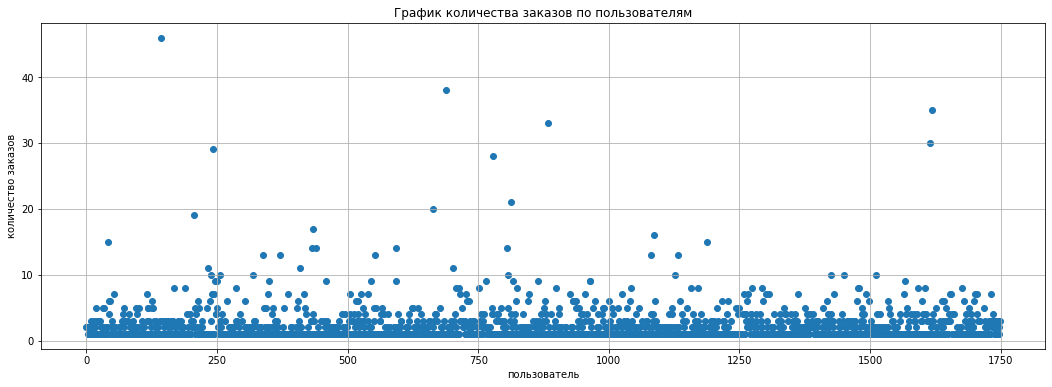

In [39]:
xx_values = pd.Series(range(0,len(customer_retail['purchase_count'])))

fig, ax = plt.subplots()
fig.set_figwidth(18)
fig.set_figheight(6)
ax.set_title('График количества заказов по пользователям')
ax.set_xlabel('пользователь')
ax.set_ylabel('количество заказов')
ax.grid()


plt.scatter(xx_values, customer_retail['purchase_count'])

Как видим, большинство пользователей совершает меньше 10 заказов, но также есть и те кто делает 20, 30 и даже 40 заказов. Для того, чтобы ответить на вопрос какое количество считать аномальным посчитаем выборочные процентили.

**Посчитать 95-й и 99-й перцентили количества заказов на пользователя. Выбрать границу для определения аномальных пользователей.** <a id="step16"></a>

In [40]:
display(np.percentile(customer_retail['purchase_count'], [95, 99]))

array([ 7.  , 13.52])

Не более 5% пользователей оформляли больше чем 7 заказов. И 1% пользователей заказывал более 13 раз. Выберем 13 заказов на одного пользователя за границу числа заказов, и отсеем аномальных пользователей по ней (при определениии границы также взглянули на график количества заказов из предыдущего пункта).

**Убрать аномальные значения из выборки** <a id="step17"></a>

---
В прошлых пунктах мы определили границы "нормальности". Уберем всех у кого больше 13 заказов и средний чек больше 3500. 

In [41]:
filtered_retail = customer_retail.query('purchase_count < 14 and 0 <= avg_bill < 3501').reset_index(drop=True)
display(filtered_retail)

,loyalty_program,customer_id,purchase_count,revenue_sum,avg_bill
0,0,18026.0,2,1736.520,868.26
1,0,18027.0,2,2004.205,1002.10
2,0,18029.0,1,386.180,386.18
3,0,18031.0,1,390.170,390.17
4,0,18038.0,2,1917.175,958.59
...,...,...,...,...,...
1630,1,23936.0,3,426.820,142.27
1631,1,23938.0,1,454.980,454.98
1632,1,23939.0,3,904.610,301.54
1633,1,23948.0,2,148.645,74.32


<div class="alert alert-block alert-info">
    
У нас было 1749 пользователей, а стало 1635, то есть мы потеряли 114 аномальных значений или 6,5% - не самая критичная цифра, которая обеспечит большую точность исследованию. Самое время сформулировать и проверить гипотезы.
    
</div>


### Шаг №4. Сформулировать и проверить гипотезы<a id="step18"></a>

---
**Формулировка гипотез**<a id="step19"></a>

---
Начнём с формулировки нулевой гипотезы H₀ (от англ. hypothesis — гипотеза; от др.-греч. ὑπόθεσις — предположение). Например, «среднее рассматриваемой генеральной совокупности равно A», где А — некоторое число. Исходя из H₀ формулируется альтернативная гипотеза H₁. Для этой H₀ она звучит как «среднее генеральной совокупности не равно A». H₀ всегда формулируется так, чтобы использовать знак равенства. Другими словами, чтобы все значения, полученные эмпирически, не были экстремальными, а лежали там, где ожидаем их найти. Например, если мы исследуем, не увеличилась ли величина, то нулевая гипотеза будет звучать: «нет, не увеличилась». Если выясняем, есть ли разница между совокупностями, то нулевая гипотеза будет такая: «нет, разницы нет, то есть исследуемые параметры равны».

Значит нулевая гипотеза будут звучать так - средний чек группы 0 не отличается от среднего чека группы 1.

А альтернативная гипотеза - средние чеки групп 0 и 1 отличны друг от друга.

В прошлых пунктах мы:

 - Оценили данные визуально и выяснили, что в данных, скорее всего, есть выбросы;
 - Увидели выбросы и нашли границу для их определения.

Настало время посчитать статистическую значимость различий в среднем чеке между группами. Начнем с подготовки данных.

**Проверить гипотезу: средний чек участников программы лояльности отличается от среднего чека остальных клиентов** <a id="step20"></a>

---
Разделим нашу выборку по принадлежности к программе лояльности: sampleA - не принадлежат, sampleВ - принадлежат. Затем посмотрим на размеры таблиц.

In [42]:
sampleA = filtered_retail.query('loyalty_program == "0"').reset_index(drop=True)
sampleB = filtered_retail.query('loyalty_program == "1"').reset_index(drop=True)
display(sampleA.shape, sampleB.shape)

(1078, 5)

(557, 5)

Размеры выборок не совпадают, от выбросов мы избавились, значит решение сравнивать по среднему правильное.

Чтобы проверить гипотезу о равенстве среднего двух генеральных совокупностей по взятым из них выборкам, применим метод

scipy.stats.ttest_ind (array1, array2, equal_var) 


Методу передают параметры:
array1, array2 — массивы, содержащие выборки;
equal_var (от англ. equal variance, «равная дисперсия») — необязательный параметр, задающий считать ли равными дисперсии выборок. Передаётся как "equal_var = True" или "equal_var = False" (True — считать, False — не считать).

In [43]:
alpha = .05 # критический уровень статистической значимости, если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(sampleA['avg_bill'], sampleB['avg_bill'])

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.05807900283433022
Не получилось отвергнуть нулевую гипотезу


p-value получился больше критического уровеня статистической значимости, причин отвергать нулевую гипотезу нет. Значит говорить о том, что средние чеки различны не приходится. Участие в программе лояльности не влияет на средний чек покупателя.

**Проверить гипотезу: выручка от участников программы лояльности отличается от выручки остальных клиентов** <a id="step21"></a>

---
Нулевая гипотеза будут звучать так - выручка от участников программы лояльности не отличается от выручки остальных клиентов.

А альтернативная гипотеза - выручка от участников программы лояльности отличается от выручки остальных клиентов.

<div class="alert alert-block alert-info">
    
Здесь нужно учесть следующий момент: карта лояльности стоит 200 рублей, то есть к выручке от каждого "лояльного" пользователя мы должны добавить 200 р. Добавим соответствующий столбец и проверим нашу гипотезу.
    
</div>

In [44]:
sampleB['revenue_sum_200'] = sampleB['revenue_sum'] + 200

In [45]:
alpha = .05 # критический уровень статистической значимости, если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(sampleA['revenue_sum'], sampleB['revenue_sum_200'])

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.06170922839383591
Не получилось отвергнуть нулевую гипотезу


p-value получился больше критического уровеня статистической значимости, причин отвергать нулевую гипотезу нет. Значит говорить о том, что выручки различны не приходится. Участие в программе лояльности не влияет на выручку от покупателя.

**Проверить гипотезу: количество покупок участников программы лояльности отличается от количества покупок остальных клиентов** <a id="step22"></a>

---
Нулевая гипотеза будут звучать так - количество покупок участников программы лояльности не отличается от количества покупок остальных клиентов.

А альтернативная гипотеза - количество покупок участников программы лояльности отличается от количества покупок остальных клиентов.

In [46]:
alpha = .05 # критический уровень статистической значимости, если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(sampleA['purchase_count'], sampleB['purchase_count'])

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.8111883610792971
Не получилось отвергнуть нулевую гипотезу


p-value получился больше критического уровеня статистической значимости, причин отвергать нулевую гипотезу нет. Значит говорить о том, что количество покупок различно не приходится. Участие в программе лояльности не влияет на количество покупок покупателя.

После проверки гипотез сделаем **вывод: различия в среднем чеке, количестве покупок и выручке не получили статистической значимости, что говорит нам о том, чтонет оснований что они отличны у тех кто участвует в системе лояльности итех кто нет.**

### Шаг №5. Сформулировать выводы и сделайте базовые рекомендации по использованию программы лояльности<a id="step23"></a>

---
Подведем итоги нашего исследования:
1. Предобработка данных. Мы получили довольно "сырые данные" и сделали с ними следующие преобразования:
 - названия столбцов приведены к нижнему регистру и переименованы на более удобные.
 - данные приведены к нужным типам
 - пропуски обработаны и при этом мы не потеряли около 35 тысяч записей как если бы просто удалили их.
 - дубликаты удалены, как полные строки - в таблице retail, так и одинаковые ИД товара - в таблице продуктовых кодов. Параллельно с этим создан датафрейм с уникальными парами код-цена, где цену мы взяли как медиану по ценам каждого уникального товара. Таблицы после всех обработок мы объединили, получив общий датафрейм со всеми интересующими нас данными.
2. Исследовательский анализ данных (EDA). В результате анализа мы получили следующую информацию:
 - представлены данные с 2016-12-01 по 2017-02-28
 - до середины декабря покупок было значительно больше, чем в январе и феврале
 - отсутствуют данные с 24 декабря по 3 января и также данные для 1 дня в неделю: 4.12, 11.12, 18.12 и так далее
 - количество покупок вне программы лояльности больше, чем число покупок по программе
 - количество покупок по пользователя в среднем равны для тех кто в системе лояльности и тех кто нет
 - подавляющее большинство покупок приходятся на магазин "shop_0" - 3134 и 1337 чеков на нелояльных и лояльных соответственно - скорее всего он единственный занимается оптом
 - "лояльные" покупатели совершают покупки только в 4 магазинах: 0, 8, 19 и 28
 - только у четырех магазинов набралось более 20 продаж: 1, 4, 6, 12 (не считая 0). Это очень низкий показатель для трехмесячного периода. Встает резонный вопрос о целесообразности содержать столько магазинов
 - мы отбросили порядка 6,5% аномальных по количеству и среднему чеку заказов
3. Сформулировали три гипотезы и проверили их:
 - средний чек участников программы лояльности отличается от среднего чека остальных клиентов
 - выручка от участников программы лояльности отличается от выручки остальных клиентов
 - количество покупок участников программы лояльности отличается от количества покупок остальных клиентов.
 
 Ни одна из них не получила статистической значимости и мы пришли к выводу что разницы в выбранных метриках между "лояльными" и "нелояльными" покупателями нет различий.
 

Несмотря на полученный результат, я считаю, что качество данных не позволило получить полностью адекватную оценку ситуации. Я бы реккомендовал разобраться почему не хватает такого количества данных по дням - может все таки данные "теряются" и мы делали оценку необъективно. Уделить внимание распределению заказов по магазинам: почему "лояльные" клиенты встречаются только в 4 магазинах (причем в 3 из них всего пара заказов) и почему только в 4 магазинах заказов больше 20. Также реккомендую провести полноценный А/В тест.

Если все-таки выгрузка верна, то я не вижу разницы между клиентами с лояльностью и без и поэтому не вижу смысла вкладывать в нее время и средства - лучше поискать другие способы повысить средний чек, выручку, количество покупок.